In [150]:
import chainer
import collections
import numpy as np
import os.path as osp
import piexif
import scipy.io

from PIL import Image


#DATASET_BRIDGE_DIR = osp.expanduser('/root/fcn/bridgedegradationseg/dataset/')
DATASET_BRIDGE_DIR = osp.expanduser('~/repos/bridgedegradationseg/dataset/')

did = 'deck_d/0063'

black_out_non_deck = False

img_file = osp.join(DATASET_BRIDGE_DIR, 'bridge_dataset/', '{}.jpg'.format(did))
lbl_file = osp.join(DATASET_BRIDGE_DIR, 'bridge_masks/', '{}.png'.format(did))
deck_file = osp.join(DATASET_BRIDGE_DIR, 'deck_masks/', '{}.png'.format(did))

class_names = np.array(['non-damage', 'delamination', 'rebar_exposure'])




def random_crop(x, y=np.array([None]), random_crop_size=None):
    w, h = x.shape[1], x.shape[0]
    rangew = (w - random_crop_size[0]) // 2
    rangeh = (h - random_crop_size[1]) // 2
    offsetw = 0 if rangew<=0 else np.random.randint(rangew)
    offseth = 0 if rangeh<=0 else np.random.randint(rangeh)
    if y.any() != None:
        return x[offseth:offseth+random_crop_size[0], offsetw:offsetw+random_crop_size[1]], \
                y[offseth:offseth+random_crop_size[0], offsetw:offsetw+random_crop_size[1]]
    else:
        return x[:, offseth:offseth+random_crop_size[0], offsetw:offsetw+random_crop_size[1]]

def color_class_label(image):
    # https://stackoverflow.com/a/33196320
    color_codes = {
        (0, 0, 0): 0,
        (255, 255, 0): 1,
        (255, 0, 0): 2
    }

    color_map = np.ndarray(shape=(256*256*256), dtype='int32')
    color_map[:] = -1
    for rgb, idx in color_codes.items():
        rgb = rgb[0] * 65536 + rgb[1] * 256 + rgb[2]
        color_map[rgb] = idx

    image = image.dot(np.array([65536, 256, 1], dtype='int32'))
    return color_map[image]


def black_out_non_deck_fn(img, lbl, deck):
    assert deck.shape[0:2] == img.shape[0:2]
    assert img.shape[2] == 3
    assert len(deck.shape) == 2
    assert lbl.shape == deck.shape
    deck = deck/255  #so that deck is 1 or 0
    lbl[deck==0] = -1  #make everything none deck as class -1
    deck = np.repeat(deck[:,:,np.newaxis], 3, axis=2)  #duplicate deck into the 3rd dimension
    img = img * deck.astype('uint8') 
    return img, lbl

        
def get_example(index):

    piexif.remove(img_file)
    img = Image.open(img_file)
    # wsize = int(float(img.size[0]) * 0.5)
    # hsize = int(float(img.size[1]) * 0.5)
    # img = img.resize((wsize, hsize))
    lbl = Image.open(lbl_file)
    # lbl = lbl.resize((wsize, hsize))

    img = np.array(img, dtype=np.uint8)
    lbl = np.array(lbl, dtype=np.uint32)
    lbl = self.color_class_label(lbl)

    if black_out_non_deck:
        deck_file = data_file['deck']
        deck = Image.open(deck_file)
        deck = np.array(deck, dtype=np.uint32)
        img, lbl = self.black_out_non_deck_fn(img, lbl, deck)

    if self.rcrop.any() != None:
        img,lbl = self.random_crop(img,lbl, self.rcrop)
    return img, lbl



In [111]:
import imgaug as ia
from imgaug import augmenters as iaa

import matplotlib.pyplot

In [137]:
ia.seed(42)
seq = iaa.Sequential([
    iaa.Fliplr(0.5, name='Fliplr'),
    iaa.Flipud(0.5, name='Flipud'),
    iaa.Sometimes(0.5, iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, rotate=(-45, 45), shear=(-15, 15), name='Affine')),
    iaa.SomeOf((0,1), [ #pick from 0 up to 1 out of the following to apply
        iaa.ContrastNormalization((0.75, 1.5), name='ContrastNormalization'),     
        iaa.Multiply((0.8, 1.2), name='Multiply')
    ], random_order=True)
])
def activator_lbl(images, augmenter, parents, default):
    if augmenter.name in ['ContrastNormalization', 'Multiply']:  #all these will not be performed on the labels
        return False
    else:
        # default value for all other augmenters
        return default
hooks_lbl = ia.HooksImages(activator=activator_lbl)

In [145]:
def augment_image(img, lbl):
    
    seq_det = seq.to_deterministic() #seq_det is now a fixes sequence, so lbl and deck get treated the same as img
                                     #it will be a new one after each call of seq.to_deterministic()
        
    img = seq_det.augment_image(img)
    lbl = seq_det.augment_image(lbl, hooks=hooks_lbl)
         
        
    return img, lbl

    

[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]


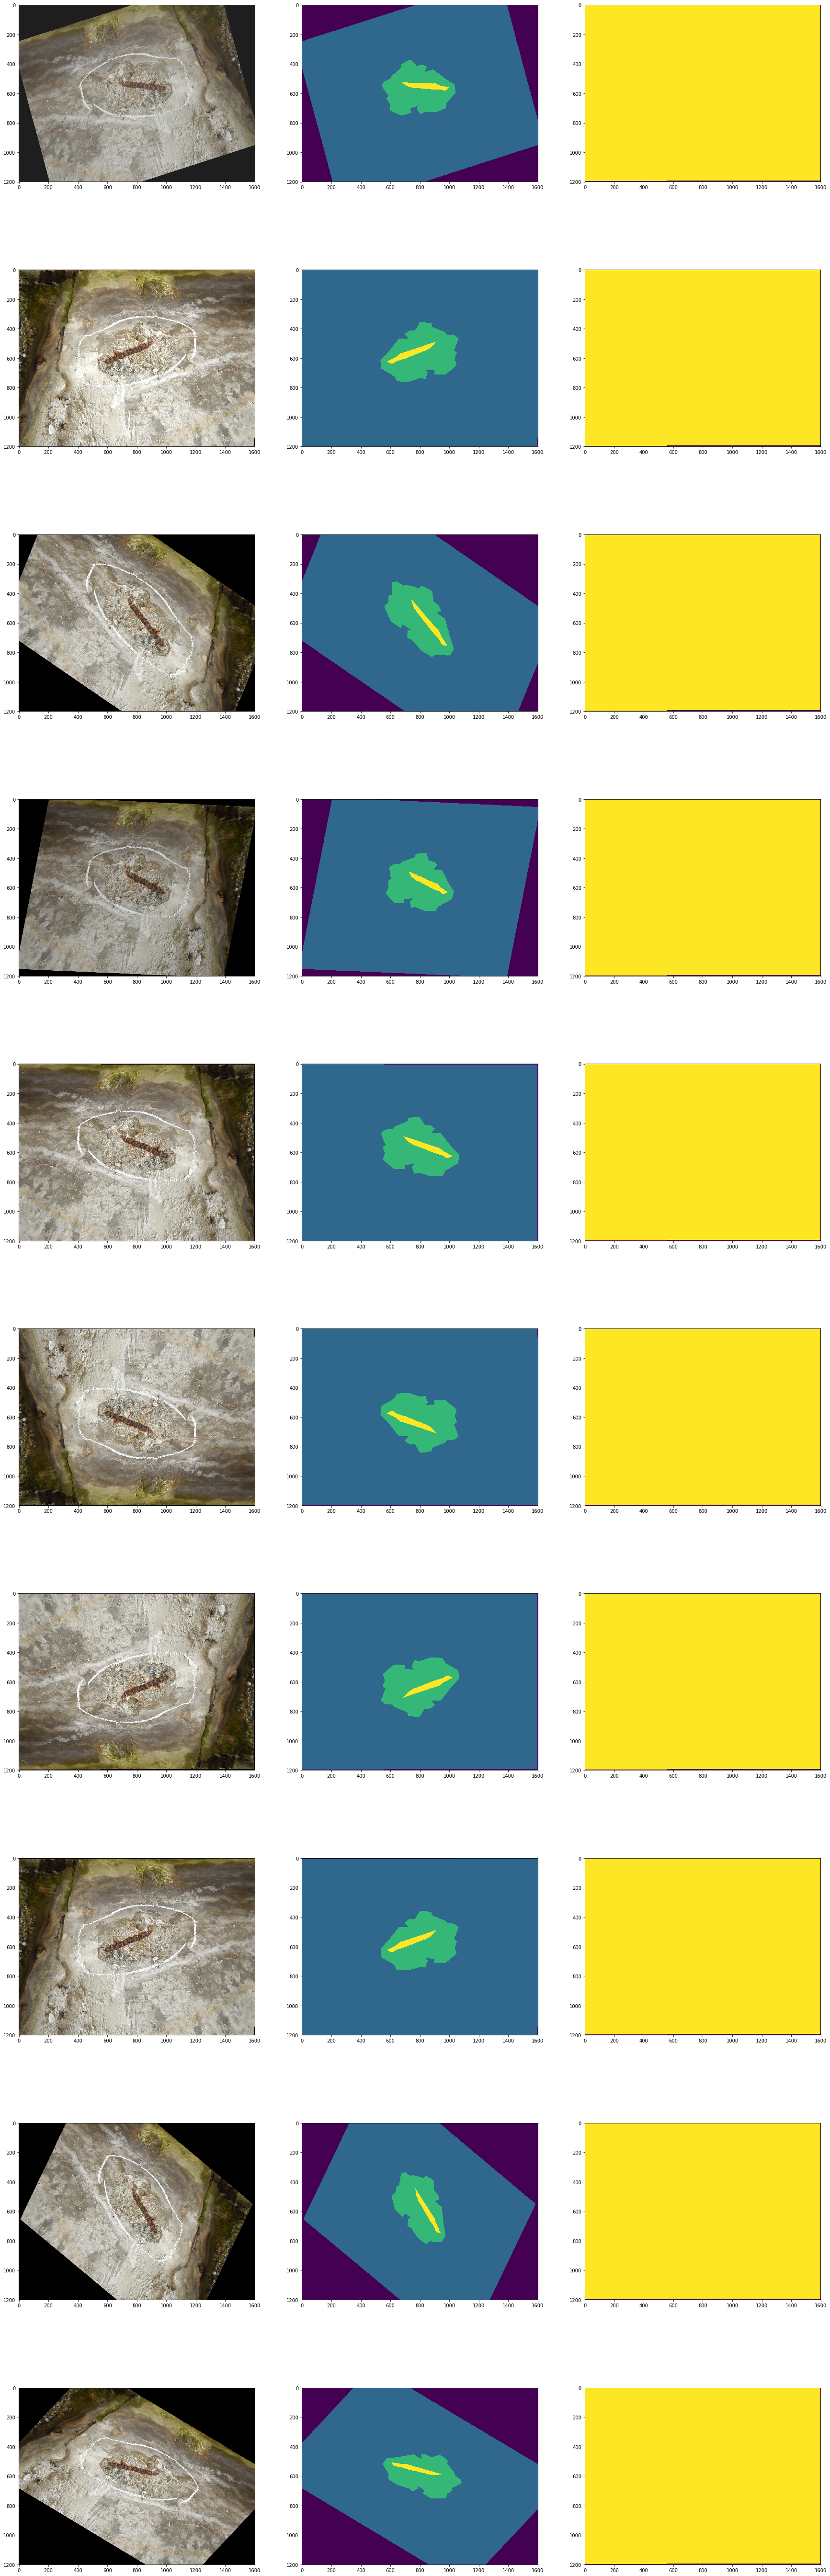

In [154]:
fig=matplotlib.pyplot.figure(figsize=(30, 100))
nums = 10
for i in range(nums):

    img = Image.open(img_file)
    lbl = Image.open(lbl_file)
    deck = Image.open(deck_file)
    img = np.array(img, dtype=np.uint8)
    lbl = np.array(lbl, dtype=np.uint32)
    deck = np.array(deck, dtype=np.uint32)

    lbl = color_class_label(lbl)
    
    img, lbl = black_out_non_deck_fn(img, lbl, deck)
    
    img,lbl = random_crop(img,lbl, [2500, 2500])

    lbl+=1 #imaug library pads with 0. We want the label to be padded with 'non-deck', which has the label -1, hence this cheap hack
    img, lbl = augment_image(img,lbl)
    lbl-=1
    #if np.unique(lbl).shape[0] > len(self.class_names):
    if np.unique(lbl).shape[0] > 4:
        print('WARNING: someting is odd about the number of labeled classes in this image, the are {}'.format(np.unique(lbl)))

    #show results
    
    lbl+=1 #just for visualization, cause matplotlib cant handle -1
    fig.add_subplot(nums, 3, i*3+1)
    matplotlib.pyplot.imshow(img)
    fig.add_subplot(nums, 3, i*3+2)
    matplotlib.pyplot.imshow(lbl.astype(np.uint8))
    fig.add_subplot(nums, 3, i*3+3)
    matplotlib.pyplot.imshow(deck.astype(np.uint8))
    print(np.unique(lbl))
matplotlib.pyplot.show()

In [106]:
np.unique(lbl).shape[0]

1

In [87]:
lbl

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)